In [1]:
import sys, os, json, pickle, gzip, copy, torch, numbers
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.data import ReactionDataset, ReactionGraphDataset
from src.utils import ActiveElements, MetalElements, Element, AllElements, composit_parser
from src.feature import composition_to_feature
from pymatgen.core import Composition
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR

# ELMD

In [ ]:
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)
with gzip.open('../data/screened_precursor.pkl.gz','rb') as f:
    screened_precursor = pickle.load(f)
num_eles = np.zeros((len(ActiveElements), 2))

for data in unique_target:
    for ele, frac in data['target_comp'].items():
        i = ActiveElements.index(ele)
        num_eles[i, 0] += data['count']
for data in screened_precursor.values():
    for ele, frac in data['precursor_comp'].items():
        i = ActiveElements.index(ele)
        num_eles[i, 1] += data['count']

In [ ]:
elmd = {}
for fn in os.listdir('../src/elmd'):
    if not fn.endswith('json'): continue
    elmd[fn.split('.')[0]] = json.load(open(f'../src/elmd/{fn}'))

for fn, data in sorted(elmd.items(), key=lambda x: x[0]):
    dtype = []
    dlen = []
#    ele_not_in_table = []
    for ele, feat in data.items():
        dtype.append(str(type(feat)).split()[1].replace('>','').replace('\'',''))
        if isinstance(feat, (int, float)):
            dlen.append(1)
        else:
            dlen.append(len(feat))
#    for ele in elmd['atomic'].keys():
#        if ele not in data.keys() and ele not in 'DTUue':
#            ele_not_in_table.append((ele, Element(ele).number))
    ele_not_in_data = {}
    for i, ele in enumerate(ActiveElements):
        if ele not in data.keys() and num_eles[i].sum() != 0:
            ele_not_in_data[ele] = num_eles[i, :]
    print(fn, dtype[0], dlen[0], len(dtype))
#    print(ele_not_in_table)
    if len(ele_not_in_data) != 0:
        print(ele_not_in_data)
#    print(ele_not_in_table)
#    print()
    

In [ ]:
len(ActiveElements)


# Composition featurization functions

In [24]:
with gzip.open('../data/unique_ligand.pkl.gz','rb') as f:
    unique_ligand = pickle.load(f)
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)
with gzip.open('../data/unique_target.pkl.gz','rb') as f:
    unique_target = pickle.load(f)

In [ ]:
from src.feature import composition_to_feature

composition_to_feature({'Li':0.2, 'Co':0.2, 'O':0.6}, feature_type='magpie')

In [ ]:
fgs = {}
mask = np.ones(len(unique_precursor), dtype=bool)
for ele in MetalElements:
    precs = []
    for i, prec in enumerate(unique_precursor):
        if ele not in prec['precursor_comp'].keys(): continue
        precs.append([len(prec['years']), prec['precursor_comp']])
        mask[i] = False
    precs = sorted(precs, key=lambda x: x[0], reverse=True)
    precs = sorted(precs, key=lambda x: len(list(x[1].keys())))
    precs = sorted(precs, key=lambda x: tuple(list(x[1].keys())))
    for prec in precs:
        n = np.min(list(prec[1].values()))
        p = '   '.join([f'{e:2s}:{f/n:.2f}' for e, f in prec[1].items()])
        print('{:5d} : {}'.format(prec[0], p))
    if len(prec) != 0:
        print()

precs = []
for j in np.where(mask)[0]:
    prec = unique_precursor[j]
    precs.append([len(prec['years']), prec['precursor_comp']])
            
precs = sorted(precs, key=lambda x: x[0], reverse=True)
precs = sorted(precs, key=lambda x: len(list(x[1].keys())))
precs = sorted(precs, key=lambda x: tuple(list(x[1].keys())))
for prec in precs:
    n = np.min(list(prec[1].values()))
    p = '   '.join([f'{e:2s}:{f/n:.2f}' for e, f in prec[1].items()])
    print('{:5d} : {}'.format(prec[0], p))

In [ ]:
fgs = {}
for prec in unique_precursor:
    n = len(prec['years'])
    metals = {}
    non_metals = {}
    for e, f in prec['precursor_comp'].items():
        if e in MetalElements:
            metals.update({e:f})
        else:
            non_metals.update({e:f})
    k_m = tuple(sorted(list(metals.keys()), key=lambda x: Element(x).number))
    k_fg = tuple(sorted(list(non_metals.keys()), key=lambda x: Element(x).number))
    if k_fg not in fgs.keys():
        fgs[k_fg] = {'count':0, 'metals':{}}
    if k_m not in fgs[k_fg]['metals']:
        fgs[k_fg]['metals'][k_m] = {
            'count':0, 'case':[]
        }
    fgs[k_fg]['count'] += n
    fgs[k_fg]['metals'][k_m]['count'] += n
    fgs[k_fg]['metals'][k_m]['case'].append([prec['precursor_comp'], n])

In [ ]:
fgs = {k:v for k,v in sorted(fgs.items(), key=lambda x: len(x[0]))}
fgs = {k:v for k,v in sorted(fgs.items(), key=lambda x: x[0])}
fgs = {k:v for k,v in sorted(fgs.items(), key=lambda x: x[1]['count'])}
for k, v in fgs.items():
    m = list(v['metals'].keys())
    print(k, v['count'], f'{len(m)}/{len(MetalElements)}')
    print(m)
    print()

NameError: name 'unique_reaction' is not defined

# Precursor dataset 

In [ ]:
DS = ReactionDataset()
DS.from_file('../data/screened_unique_reaction.pkl.gz')

## basic

embedding 및 label 관리를 위해 따로 만들 필요가 있음

In [ ]:
#완성 후 삭제함
from src.feature import PrecursorDataset
PDS = PrecursorDataset()

### precursor mask

In [ ]:
mat = np.zeros((PDS.NUM_LABEL, len(MetalElements)+1), dtype=bool)
for i, prec in enumerate(PDS.precursor_source):
    for ele in prec['precursor_comp'].keys():
        if ele in MetalElements:
            j = MetalElements.index(ele)
            mat[i, j] = True
    if mat[i].sum() == 0:
        mat[i, -1] = True
mat = mat.T

In [ ]:
z = np.matmul(mat.T, mat)

In [ ]:
k = -1
js = np.where(mat[k])[0]
print(MetalElements[k] if k != -1 else 'None', mat[k].sum())
print(js)
for i, j in enumerate(js):
    print('{:2d} {:4d} {:2d}  {}'.format(i, j, int(((z[j] & mat[k]) != mat[k]).sum() == 0), PDS.precursor_source[j]['precursor_comp']))
#np.where(z[0]), np.where(z[43]), np.where(z[180])

In [ ]:
mat[-1]

In [ ]:
for j in np.where(mat[:, k])[0]:
    print(PDS.precursor_source[j]['precursor_comp'])

In [ ]:
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    dataset = pickle.load(f)
pstrs = []
for data in dataset:
    for prec in data['precursor_comp']:
        pstr = composit_parser(prec)
        if pstr not in pstrs:
            pstrs.append(pstr)
PDS.update(pstrs)


In [ ]:
for j in np.where(PDS.precursor_mask[-1])[0]:
    print(j, PDS.label_to_precursor[j])

In [ ]:

def get_precursor_mask_from_target(self, target):
    mask = self.precursor_mask[-1].copy()
    for ele in target.keys():
        if ele in MetalElements:
            mask = mask | self.precursor_mask[MetalElements.index(ele)]
    return mask

target = dataset[0]['target_comp']
mask = get_precursor_mask_from_target(PDS, target)
print(target)
for j in np.where(mask)[0]:
#    print(j)
    out = PDS.get_precursor_info(j)[1]
    if isinstance(out, dict):
        print(out['precursor_comp'])
    else:
        print(out)
    #['precursor_comp']
#PDS.label_to_precursor[j]
#PDS.get_precursor_info(9)


### precursor mask의 적합성 확인

In [ ]:
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    dataset = pickle.load(f)

In [ ]:
for data in dataset:
    m = np.zeros((len(MetalElements), 2), dtype=int)
    for ele in data['target_comp'].keys():
        if ele not in MetalElements: continue
        i = MetalElements.index(ele)
        m[i,0] += 1 
    for prec in data['precursor_comp']:
        for ele in prec.keys():
            if ele not in MetalElements: continue
            i = MetalElements.index(ele)
            m[i,1] += 1
    i, j = m.sum(0)
    if (i != j) and (np.sum(m[:, 1][m[:, 0] != 0] == 0) != 0):
        print(m[m[:, 1] != 0].T)

# target에 있는 모든 metal element는 precursor에 포함되어 있음.
# precursor에 있는 모든 metal element는 target에 포함되어 있음.

### Precursor 유사도

In [ ]:
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    dataset = pickle.load(f)
    
labels = []
coprecursorset = []
for d in dataset:
    precursor_set = {}
    for p in d['precursor_comp']:
        pstr = composit_parser(p)
        if pstr not in PDS.precursor_to_label.keys(): continue
        labels.append(PDS.precursor_to_label[pstr])
        metal = [e for e in p.keys() if e in MetalElements]
        if len(metal) == 0:
            continue
        else:
            metal = metal[0]
        if metal not in precursor_set.keys():
            precursor_set[metal] = []
        precursor_set[metal].append(pstr)
    for v in precursor_set.values():
        if len(v) > 1:
            coprecursorset.append(v)

counts = np.zeros(500)
for i, c in zip(*np.unique(labels, return_counts=True)):
    counts[i] = c

In [ ]:
np.unique([len(c) for c in coprecursorset], return_counts=True)

In [ ]:
# active_precs = []
# for data in dataset:
#     for prec in data['precursor_comp']:
#         pstr = composit_parser(prec)
#         if pstr in active_precs:
#             continue
#         active_precs.append(pstr)
# PDS.update(active_precs)

In [ ]:
from src.feature import MetalElements
k = 0
for i, mask in enumerate(PDS.precursor_mask):
    if mask.sum() == 0: continue
    js = np.where(mask)[0]
    k += 1
    #if i < len(MetalElements) and MetalElements[i] not in 'PuNp': continue
    if len(js) < 10: continue
    print(k, MetalElements[i] if i < len(MetalElements) else 'None', '-'*50)
    print(''.join([f'{j:4d}' for j in js]))
    print(''.join([f'{counts[j]:4.0f}' for j in js]))


In [ ]:
feat_types = ['composit', 'cgcnn', 'magpie_sc', 'mat2vec', 'matscholar', 'megnet16']
full_vectors = {ftype: np.vstack([composition_to_feature(prec['precursor_comp'], ftype) for prec in PDS.precursor_source]) for ftype in feat_types}
fg_vectors = {ftype: np.vstack([composition_to_feature({k:v for k,v in prec['precursor_comp'].items() if k not in MetalElements}, ftype) for prec in PDS.precursor_source]) for ftype in feat_types}
fgs = np.array([composit_parser({k:v for k,v in prec['precursor_comp'].items() if k not in MetalElements}) for prec in PDS.precursor_source])
element_source = [np.where(m)[0][0] if m.sum() != 0 else -1 for m in PDS.precursor_mask[:-1, :-2].T]

In [ ]:
(fg_vectors['composit'] != 0).sum(0)

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE

labels = {}
for ftype in feat_types:
    for n_cluster in [10, 15, 20, 25]:        
        labels[f'{ftype}+full+{n_cluster}'] = []
        labels[f'{ftype}+fg+{n_cluster}'] = []
        for seed in range(1000):
            full_labels = KMeans(n_cluster, random_state=seed, n_init='auto').fit_predict(full_vectors[ftype])
            fg_labels = KMeans(n_cluster, random_state=seed, n_init='auto').fit_predict(fg_vectors[ftype])
            labels[f'{ftype}+full+{n_cluster}'].append(full_labels)
            labels[f'{ftype}+fg+{n_cluster}'].append(fg_labels)

In [ ]:
def get_matrix(data, cutoff=50):
    matrix = np.zeros((len(data[0]), len(data[0])))
    for labels in data[:cutoff]:
        for i, label_i in enumerate(labels):
            for j, label_j in enumerate(labels[i+1:]):
                if label_i != label_j: continue
                matrix[i,i+j+1] += 1
                matrix[i+j+1,i] += 1
    return matrix

coassignment_matrices = {}
consensus_labels = {}
for ftype, label in labels.items():
    for n in [50, 100, 200, 500, 1000]:
        coassignment_matrices[f'{ftype}+{n}'] = get_matrix(label, n)
        agc = AgglomerativeClustering(n_clusters=8, metric='precomputed', linkage='average')
        consensus_labels[f'{ftype}+{n}'] = agc.fit_predict(1 - coassignment_matrices[f'{ftype}+{n}'] / n)

with open('../dump/coassignment_matrices.pkl','wb') as f:
    pickle.dump(coassignment_matrices, f)
with open('../dump/consensus_labels.pkl','wb') as f:
    pickle.dump(consensus_labels, f)

In [ ]:
#plt.pcolormesh(coassignment_matrices['cgcnn+fg+10+100'])
mat = get_matrix(np.vstack([v for v in labels.values()]), cutoff=1000000)

In [ ]:
with open('../dump/coassignment_matrix_all.pkl','wb') as f:
    pickle.dump(mat, f)

In [ ]:
for i, (prec, count) in enumerate(zip(*np.unique(fgs, return_counts=True))):
    print(f'{i:3d} - {count:3d} : {prec:30s}')

In [ ]:
agc = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='average')
label = agc.fit_predict(1 - mat / mat.max())


In [ ]:
a, b = 0.23529, 0.70588
c = 1 - a - b
1, 4, 12



In [ ]:
np.unique(label, return_counts=True)

In [ ]:
with open('../dump/coassignment_matrices.pkl','rb') as f:
    coassignment_matrices = pickle.load(f)
with open('../dump/consensus_labels.pkl','rb') as f:
    consensus_labels = pickle.load(f)

In [ ]:
print(np.unique(consensus_labels['composit+full+20+500'], return_counts=True))
print(np.unique(consensus_labels['composit+full+20+1000'], return_counts=True))

In [ ]:
print(np.unique(consensus_labels['composit+fg+10+50'], return_counts=True))
print(np.unique(consensus_labels['composit+fg+10+1000'], return_counts=True))

In [ ]:
consensus_labels['composit+fg+10+50'][consensus_labels['composit+fg+10+1000'] == 3]


In [ ]:
from scipy.optimize import linear_sum_assignment

def align_labels(labels_1, labels_2, num_clusters=8):
    cost_matrix = np.zeros((num_clusters, num_clusters))
    for i in range(num_clusters):
        for j in range(num_clusters):
            cost_matrix[i, j] = np.sum((labels_1 == i) & (labels_2 == j))
    _, col_ind = linear_sum_assignment(-cost_matrix)
    new_labels_2 = np.zeros_like(labels_2)
    for i, idx in enumerate(col_ind):
        new_labels_2[labels_2 == i] = idx
    return new_labels_2

for desc_0 in consensus_labels.keys():
    labels_1 = consensus_labels[desc_0]
    prefix = '+'.join(desc_0.split('+')[:2])
    for desc, labels in consensus_labels.items():
        if desc == desc_0: continue
        if not desc.startswith(prefix): continue
#    if not desc.startswith('composit+full'):
#        continue
        labels_2 = align_labels(labels_1, labels)
        consensus_labels[desc] = labels_2

In [ ]:
descs = consensus_labels.keys()
for desc_i in descs:
    prefix = '+'.join(desc_i.split('+')[:2])
    labels_i = consensus_labels[desc_i]
    for desc_j in descs:
        if not desc_j.startswith(prefix): continue
        labels_j = consensus_labels[desc_j]

#labels_3 = align_labels(labels_1, labels_2)



### eos and sos

In [ ]:
PDS.update(DS)
#PDS.source_to_label[DS[0].labels]

#PDS.label_to_precursor[412]
#PDS.source_to_label[DS[0].labels], DS[0].labels
PDS.get_precursor_data('SOS')

In [ ]:
import gzip, pickle
path = '../data/screened_precursor.pkl.gz'
with gzip.open(path, 'rb') as f:
    unique_precursor = pickle.load(f)
unique_precursor[:4]


## Functional Group Dataset 

In [8]:
with gzip.open('../data/unique_precursor.pkl.gz','rb') as f:
    unique_precursor = pickle.load(f)    
with gzip.open('../data/screened_precursor.pkl.gz','rb') as f:
    screened_precursor = pickle.load(f)
with gzip.open('../data/unique_reaction.pkl.gz','rb') as f:
    unique_reaction = pickle.load(f)
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    screened_unique_reaction = pickle.load(f)

### building

In [ ]:
import numpy as np
from src.feature import MetalElements, AllElements

class LigandTemplateDataset:
    def __init__(self, 
                 feat_type:str = 'composit',
                 by_fraction:bool = True,
                 *args, **kwargs):
        self._feat_type = feat_type
        self._by_fraction = by_fraction

#        path = os.path.join(os.path.dirname(os.path.abspath(__file__)), '../data/screened_precursor.pkl.gz')
        path = '../data/screened_precursor.pkl.gz'

        with gzip.open(path, 'rb') as f:
            self._precursor_source = pickle.load(f)
        self._active_precursors = [p['precursor_str'] for p in self._precursor_source]
        self._precursor_to_source = {c:i for i,c in enumerate(self._active_precursors)}
#        self._source_vecs = np.vstack([composition_to_feature(c) for c in self._active_precursors])
        self._metal_indexer = {'none': 0}
        self._metal_indexer.update({metal:i+1 for i,metal in enumerate(MetalElements)})
        self.update()

    def update(self, active_precursors=None):
        if not isinstance(active_precursors, (list, np.ndarray, tuple, set)):
            active_precursors = self._active_precursors
        _active_precursors = []
        self._ligand_dict = {}
        for i_src, precursor in enumerate(self._precursor_source):
            if precursor['precursor_str'] not in active_precursors:
                continue
            _active_precursors.append(precursor['precursor_str'])
            n_total = np.sum(list(precursor['precursor_comp'].values()))
            i_metal = 0
            non_metal = {}
            for ele, n in precursor['precursor_comp'].items():
                if ele in MetalElements:
                    i_metal = self._metal_indexer[ele]
                else:
                    non_metal[ele] = n/n_total
            ligand_str = composit_parser(non_metal)
            if ligand_str not in self._ligand_dict.keys():
                self._ligand_dict[ligand_str] = {
                    'label':None, 
                    'composition':non_metal,
                    'embedding': composition_to_feature(composit_dict = non_metal, 
                                                        feature_type = self._feat_type,
                                                        by_fraction = self._by_fraction,
                                                        norm=False).reshape(1,-1),
                    'metals':[]}
            self._ligand_dict[ligand_str]['metals'].append((i_metal, i_src))

        self.NUM_LABEL = len(self._ligand_dict)
        self._active_precursors = _active_precursors.copy()

        self._source_to_label = np.zeros((len(self._precursor_source), 2), dtype=int)
        self._label_to_source = - np.ones((len(MetalElements)+1, self.NUM_LABEL), dtype=int)
        self._ligand_str = list(self._ligand_dict.keys())
        for j, ligand_info in enumerate(self._ligand_dict.values()):
            ligand_info['label'] = j
            for i, i_source in ligand_info['metals']:
                self._label_to_source[i, j] = i_source
                self._source_to_label[i_source] = i, j

    def save(self, path, fn='precursor_data.json'):
        info = {
            'feat_type': self._feat_type,
            'by_fraction': self._by_fraction,
            'active_precursors': self._active_precursors,
        }
        with open(os.path.join(path, fn), 'w') as f:
            json.dump(info, f, indent=4)
    
    def load(self, path, fn='precursor_data.json'):
        with open(os.path.join(path, fn), 'r') as f:
            info = json.load(f)
        self.__init__(feat_type = info['feat_type'],
                      by_fraction = info['by_fraction'],
                      norm = info['norm'])
        self.update(info['active_precursors'])
        return self

    def _check_valid_precursor(self, *args, exit=True):
        i_src = None
        if len(args) == 1:
            if isinstance(args[0], dict):
                div = np.sum(list(args[0].values()))
                precursor = composit_parser({e:n/div for e,n in args[0].items()})
            elif isinstance(args[0], str):
                precursor = args[0]
            elif exit:
                raise ValueError('Precursor must be either `dict` or `str`, got', type(args[0]))
            try:
                i_src = self._precursor_to_source[precursor]
            except:
                i_src = None
        elif len(args) > 1:
            metal, ligand = args[:2]
            i_metal, i_ligand = None, None
            if isinstance(metal, str) and (metal in self._metal_indexer):
                i_metal = self._metal_indexer[metal]
            elif isinstance(metal, numbers.Integral) and metal < len(MetalElements) + 1:
                i_metal = metal
            if isinstance(ligand, str) and (ligand in self._ligand_dict.keys()):
                i_ligand = self._ligand_dict[ligand]['label']
            elif isinstance(ligand, numbers.Integral) and ligand < len(self._ligand_dict):
                i_ligand = ligand
            if (i_metal is None) or (i_ligand is None):
                i_src = None
            else:
                i_src = self._label_to_source[i_metal, i_ligand]
            if i_src == -1:
                i_src = None
        if (i_src is None) and exit:
            raise ValueError('Invalid precursor', args)
        return i_src        

    def to_label(self, *args):
        i_source = self._check_valid_precursor(args)
        _, label = self._source_to_label[i_source]
        return label

    def get_embedding(self, *args):
        i_src = self._check_valid_precursor(args, exit=False)
        if i_src is None:
            return composition_to_feature({}, feature_type=self._feat_type, by_fraction=self._by_fraction)
        else:
            _, i_ligand = self._source_to_label[i_src]
            return self._ligand_dict[self._ligand_str[i_ligand]]['embedding']
    
    def get_info(self, *args):
        i_source = self._check_valid_precursor(*args)
        return self._precursor_source[i_source]
    
    def get_mask(self, metal):
        if metal in MetalElements:
            i_metal = MetalElements.index(metal) + 1
        else:
            i_metal = 0
        return (self._label_to_source[i_metal] != -1).reshape(1,-1)

    def to_dict(self):
        return {
            'feature_type': self._feat_type, 
            'NUM_LABEL': self.NUM_LABEL,
        }

In [ ]:
test = LigandTemplateDataset()
#test.update([p['precursor_str'] for p in screened_precursor])

In [ ]:
np.repeat(test.get_embedding(), 4, axis=0).shape

In [ ]:
np.where(test._label_to_source[0] != -1)

In [ ]:
#mask[0]
metals, mask = test.get_ligand_mask_from_target({'Ti':0.111, 'Li':0.3333, 'Co':0.3333, 'O':0.666667})
for mele, m in zip(metals, mask):
    for (ligand, metal), active in zip(test._ligand_dict.items(), m):
        if not active: continue
        print(mele in [_m[0] for _m in metal['metals']], mele, '   {:3f}   '.format(np.sum(list(metal['composition'].values()))), ligand)

### how to manage?

In [ ]:

count_precursor = {}
for data in unique_reactions:
    for p in data['precursor_comp']:
        comp = Composition(p)
        new_comp = str(Composition(comp.get_integer_formula_and_factor()[0]))
        if new_comp not in count_precursor.keys():
            count_precursor[new_comp] = 0
        count_precursor[new_comp] += 1

prec_comps = []
for prec in screened_precursor:
    comp = Composition(prec['precursor_comp'].items())
    new_comp = Composition(comp.get_integer_formula_and_factor()[0]).as_dict()
    prec_comps.append(new_comp)
    for e, f in new_comp.items():
        if e not in MetalElements: continue
        if f != 1: print(new_comp)

In [ ]:
fgs_int = {}
fgs_norm_full  = {}
fgs_norm_metal = {}
for p in prec_comps:
    pstr = str(Composition(p))
    pc = count_precursor[pstr]
    ns = 0
    metal_n = 1
    others = {}
    metal = 'none'
    metal_ele = 'none'
    for e,n in p.items():
        ns += n
        if e in MetalElements:
            metal = f'{e}{n:.0f}'
            metal_ele = e
            metal_n = n
        else:
            others[e] = n    
    norm_by_metal = {k:v/metal_n for k,v in others.items()}
    norm_by_all = {k:v/ns for k,v in others.items()}
    intkey = str(Composition(others))
    mfrkey = str(Composition(norm_by_metal))
    frkey = str(Composition(norm_by_all))

    if intkey not in fgs_int.keys():
        fgs_int[intkey] = []
    if frkey not in fgs_norm_full.keys():
        fgs_norm_full[frkey] = []
    if mfrkey not in fgs_norm_metal.keys():
        fgs_norm_metal[mfrkey] = []
    fgs_int[intkey].append((metal, pc))
    fgs_norm_full[frkey].append((metal_ele, pc))
    fgs_norm_metal[mfrkey].append((metal_ele, pc))    

In [ ]:
metal_int = {}
metal_fr = {}
for e in MetalElements:
    metal_int[e] = {}
    metal_fr[e] = {}
    for prec in prec_comps:
        if e not in prec.keys():
            continue
        ns = np.sum([v for v in prec.values()])
        mc = [v for e,v in prec.items() if e in MetalElements][0]
        prec_str = str(Composition(prec))
        fg_int = str(Composition({e:v for e,v in prec.items() if e not in MetalElements}))
        fg_fr  = str(Composition({e:v/ns for e,v in prec.items() if e not in MetalElements}))
        if fg_int not in metal_int[e].keys():
            metal_int[e][fg_int] = [0, []]
        if fg_fr not in metal_fr[e].keys():
            metal_fr[e][fg_fr] = [0, []]
        metal_int[e][fg_int][0] += count_precursor[prec_str]
        metal_int[e][fg_int][1].append(mc)
        metal_fr[e][fg_fr][0] += count_precursor[prec_str]
        metal_fr[e][fg_fr][1].append(mc)
    if len(metal_int[e]) > 1:
        print(e, '-' * 50)
        for p, (c, mcs) in metal_int[e].items():
            print(f'    {p:15s} : {c:4d} / {mcs}')

In [ ]:
import re
num = re.compile(r'\d')
for data_dict in [fgs_int, fgs_norm_full, fgs_norm_metal]:
    for fg, metals in data_dict.items():
        for i, (metal_i, c_i) in enumerate(metals):
            ele_i = num.sub('', metal_i)
            for j, (metal_j, c_j) in enumerate(metals[i+1:]):
                ele_j = num.sub('', metal_j)
                if ele_i == ele_j:
                    print(fg, '-', metal_i, c_i, metal_j, c_j)
    print('--')

In [ ]:
def draw_by_fg(ax, data):
    fgs, n_metals, n_precs = np.array([[fg, len(metals), np.sum([m[1] for m in metals])] for fg, metals in data.items()]).T
    n_precs = n_precs.astype(float)
    n_metals = n_metals.astype(float)
    o1 = np.argsort(n_precs)[::-1]
    o = sorted(o1, key=lambda x: n_metals[x], reverse=True)
    x = np.arange(len(n_metals))
    ax2 = ax.twinx()
    ax.plot(x, n_metals[o], '-o', color='b')
    for i in range(0, len(n_metals), 10):
        ax.axvline(i, ls='--', color='k', lw=0.5)
    for i in range(0,70,10):
        ax.axhline(i, ls='--', color='k', lw=0.5)
    ax2.plot(x, n_precs[o], '-o', color='r')
    ax2.set_yscale('log')
    ax2.set_ylim([2, 1e5])
    ax.set_xlabel('Ligands', fontsize=14)
    ax.set_ylabel('# of Metal elements', fontsize=14, color='b')
    ax2.set_ylabel('Usage', fontsize=14, color='r')


f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_fg(ax, fgs_int)
f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_fg(ax, fgs_norm_metal)
f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_fg(ax, fgs_norm_full)

In [ ]:
mat = np.zeros((len(MetalElements)+1, len(fgs_norm_full))) + 1e-4
for j, metals in enumerate(sorted(fgs_norm_full.values(), key=lambda x: len(x), reverse=True)):
    for metal, v in metals:
        if metal == 'none':
            i = 0
        else:
            i = MetalElements.index(metal) + 1
        mat[i,j] = v

In [ ]:
cmap = plt.get_cmap('viridis')
cmap.set_under([0.7,0.7,0.7])
f, ax = plt.subplots(1,1,figsize=(10,7))
ax.pcolormesh(np.log10(mat), cmap=cmap, vmin=0)
ax.set_ylabel('Metals', fontsize=14)
ax.set_xlabel('Ligands', fontsize=14)
for i in range(1, 12):
    ax.axvline(i * 10, ls='--', color='k', lw=0.5)
for i in range(1, 9):
    ax.axhline(i * 10, ls='--', color='k', lw=0.5)    

- 문제점
  - 금속 기준으로 normalize를 할 경우 metal-free precursor의 예측이 어려워짐
  - integer로 변경해서 사용 할 경우 큰 수가 나오는 경우가 있음 (200 이상)
- intrinsic한 parsing error로 인한 한계도 있음. 그냥 fractional로 진행


In [ ]:

def draw_by_metal(ax, data):
    _, n_fgs, n_precs = np.array([[metal, len(fgs), np.sum([m[0] for m in fgs.values()])] for metal, fgs in data.items() if len(fgs) != 0]).T
    o1 = np.argsort(n_precs.astype(float))[::-1]
    o = sorted(o1, key=lambda x: n_fgs.astype(float)[x], reverse=True)

    x = np.arange(len(n_fgs))
    ax2 = ax.twinx()
    ax.plot(x, n_fgs.astype(float)[o], '-o', color='b')
    ax2.plot(x, n_precs.astype(float)[o], '-o', color='r')
    ax2.set_yscale('log')
    ax.set_ylim([-1,23])
    ax2.set_ylim([2, 1e4])
    for i in range(0, len(n_fgs), 5):
        ax.axvline(i, ls='--', color='k', lw=0.5)
    for i in range(0,2,5):
        ax.axhline(i, ls='--', color='k', lw=0.5)
    ax.set_ylabel('# of ligands', fontsize=14, color='b')
    ax.set_xlabel('Metal elements', fontsize=14)
    ax2.set_ylabel('Usage', fontsize=14, color='r')

f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_metal(ax, metal_int)
f, ax = plt.subplots(1,1,figsize=(11,4))
draw_by_metal(ax, metal_fr)
f.subplots_adjust(hspace=0)

### normalization

In [76]:
precursor_source = {p['precursor_str']:[p['count'], p['count_rxn'], len(np.unique(p['dois']))] for p in unique_precursor}

ligand_dict = {}
counter = np.zeros((len(MetalElements)+1, 1, 10))
#for rxn in unique_reaction:
for rxn in screened_unique_reaction:
    for p in rxn['precursor_comp']:
        pstr = composit_parser(p)
        non_metal = {}
        i_metal = 0
        for ele, n in p.items():
            if ele in MetalElements:
                i_metal = MetalElements.index(ele) + 1
            else:
                non_metal[ele] = n
        ligand_str = composit_parser(non_metal, norm=False)
        if ligand_str not in ligand_dict.keys():
            ligand_dict[ligand_str] = len(ligand_dict)
            counter = np.concatenate([counter, np.zeros((len(MetalElements)+1, 1, 10))], axis=1)
        i_ligand = ligand_dict[ligand_str]
        counter[i_metal, i_ligand, 0] += 1/rxn['count']
        counter[i_metal, i_ligand, 1] += 1
        counter[i_metal, i_ligand, 2] += len(rxn['dois'])
        counter[i_metal, i_ligand, 3] = precursor_source[pstr][0]
        counter[i_metal, i_ligand, 4] = precursor_source[pstr][1]
        counter[i_metal, i_ligand, 5] = precursor_source[pstr][2]

<BarContainer object of 2 artists>

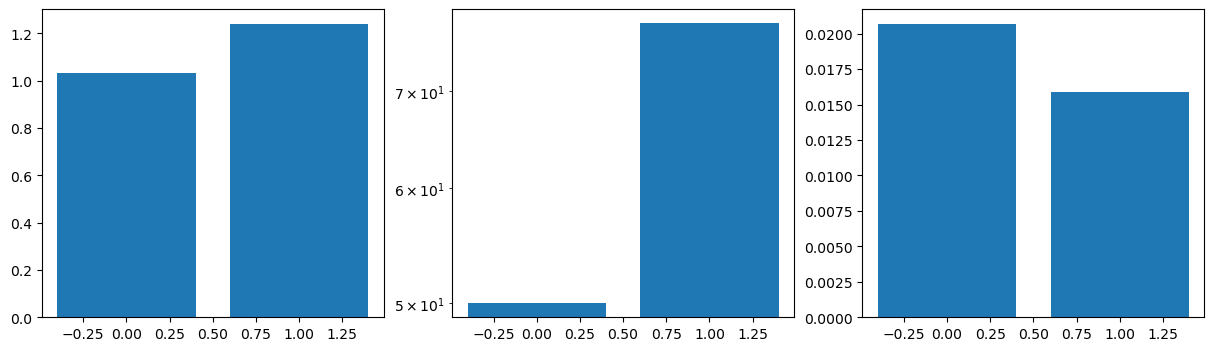

In [85]:
i = 61
mask = counter[i, :, 0] != 0

y = counter[i, mask, 0] 
m = 1 / np.power(counter[i, mask, 3], 1/1.2)
n = 1 #/ np.max(m)

f, axs = plt.subplots(1,3,figsize=(15,4))
axs[0].bar(np.arange(mask.sum()), y * m * n)
axs[1].bar(np.arange(mask.sum()), y)
axs[1].set_yscale('log')
axs[2].bar(np.arange(mask.sum()), m * n)
#counter[0].T[2]

# Data object test

In [ ]:
import sys
sys.path.append('..')
import numpy as np
import torch, os, gzip, pickle
from src.data import ReactionData
from typing import Dict, List
from src.utils import ActiveElements, MetalElements, Element
from src.feature import composition_to_feature

with gzip.open('../data/screened_conditional_reaction.pkl.gz','rb') as f:
    cond_rxn = pickle.load(f)
with gzip.open('../data/screened_unique_reaction.pkl.gz','rb') as f:
    uniq_rxn = pickle.load(f)

### speed test

In [ ]:
def fnc1(x):
    return (x + 1) ** 3
def fnc2(x):
    return (x / 2 + 1) ** 0.5
def fnc3(x):
    return (x - 1) ** 2 / 2
def fnc4(x):
    return (x + 2) ** 2

def cfn1(n, x):
    d1 = []
    d2 = []
    d3 = []
    d4 = []
    for i in range(n):
        if x:
            v2 = fnc2(i)
            v1 = fnc1(i)
            d1.append(v1)
            d2.append(v2)
        if not x:
            v3 = fnc3(i)
            v4 = fnc4(i)
            d3.append(v3)
            d4.append(v4)
    return d1, d2, d3, d4

def cfn2(n, x):
    d1 = []
    d2 = []
    d3 = []
    d4 = []    
    if x:
        d1 = [fnc1(i) for i in range(n)]
        d2 = [fnc2(i) for i in range(n)]
    if not x:
        d3 = [fnc3(i) for i in range(n)]
        d4 = [fnc4(i) for i in range(n)]
    return d1, d2, d3, d4

%timeit cfn1(500, True)
%timeit cfn2(500, True)

### check

In [ ]:
cnt = 0
for i, rxn in enumerate(uniq_rxn):
    eles = {}
    for prec in rxn['precursor_comp']:
        metal_ele = tuple([e for e in prec.keys() if e in MetalElements])
        if metal_ele not in eles.keys():
            eles[metal_ele] = 0
        eles[metal_ele] += 1
#    if np.max(list(eles.values())) > 2:
#        print(i, eles)
    if tuple([]) in eles:
        cnt += 1
        print(i, eles)
print(cnt, len(uniq_rxn))



In [ ]:
uniq_rxn[77]

In [ ]:
uniq_rxn[29022 ]

In [ ]:
uniq_rxn[7168 ]

In [ ]:
uniq_rxn[4]

### Reaction data

In [ ]:
data = uniq_rxn[0]
rxn_data = ReactionData(data = data,
                        feat_type = 'composit',
                        target_comp = data['target_comp'],
                        precursor_comps = data['precursor_comp'],
#                        conditions = ['heat_temp'],
#                        condition_values = [data['target_comp']['heat_temp']['median']],
                        weights = None)

rxn_data.precursor_feat

In [ ]:
rxn_data.labels

In [ ]:
#rxn_data.metal_feat
#rxn_data.target_feat
for f in rxn_data.precursor_feat.numpy():
    ii = np.where(f)[0]
    print(ii, [(ActiveElements[i], f[i]) for i in ii])

In [ ]:
rxn_data.precursor_feat[-1]

### Graph data

In [ ]:
class GraphData(ReactionData):
    def __init__(self, 
                 data : Dict = {},
                 feat_type : str = 'composit',
                 target_comp : Dict = {},
                 precursor_comps : List[Dict] = [],
                 conditions : List[str] = [],
                 condition_values : List[float] = [],
                 weights : float = None,
                 *args, **kwargs):
        
        super().__init__(data = data,
                         feat_type = feat_type,
                         target_comp = target_comp,
                         precursor_comps = precursor_comps,
                         conditions = conditions,
                         condition_values = condition_values,
                         weights = weights,
                         *args, **kwargs)

        # graph 
        self._feature_attrs.extend(['edge_feat','edge_index'])
        edge_index = []
        edge_feat = []
        for i, metal_i in enumerate(self.metal_comp):
            for j, metal_j in enumerate(self.metal_comp):
                edge_index.append([i,j])
                if i == j:
                    edge_feat.append(self.target_feat)
                else:
                    edge_comp = {}
                    for e, f in self.target_comp.items():
                        if e in metal_i.keys() or e in metal_j.keys():
                            edge_comp.update({e:f})
                        elif e in MetalElements:
                            continue
                        elif len(metal_i) == 0 or len(metal_j) == 0:
                            edge_comp.update({e:f})
                    edge_feat.append(
                        composition_to_feature(composit_dict = edge_comp, 
                                               feature_type = feat_type, 
                                               by_fraction = True,
                                               norm = True)
                    )
        self.edge_index = np.array(edge_index, dtype=int).T
        self.edge_feat = np.vstack(edge_feat, dtype=np.float32)

### Sequence data

In [ ]:
EOS_LABEL = 999
class SequenceData(ReactionData):
    def __init__(self, 
                 data : Dict = {},
                 feat_type : str = 'composit',
                 target_comp : Dict = {},
                 precursor_comps : List[Dict] = [],
                 conditions : List[str] = [],
                 condition_values : List[float] = [],
                 max_length : int = 8,
                 weights : float = None,
                 *args, **kwargs):
        super().__init__(data = data,
                         feat_type = feat_type,
                         target_comp = target_comp,
                         precursor_comps = precursor_comps,
                         conditions = conditions,
                         condition_values = condition_values,
                         weights = weights,
                         *args, **kwargs)
        
        self._feature_attrs.pop(self._feature_attrs.index('metal_feat'))
        delattr(self, 'metal_feat')
        self.n = max_length

        # labels & precursor feat
        pad = composition_to_feature({}, feature_type=feat_type)
        if hasattr(self, 'precursor_feat'):
            self.m = self.labels.shape[0]
            self.precursor_feat = np.vstack([
                pad.reshape(1,-1), self.precursor_feat, *[pad] * max_length
            ])[:max_length]
            self.labels = np.hstack([
                self.labels.reshape(-1), [EOS_LABEL] * max_length
            ])[:max_length].astype(int)
        else:
            self._feature_attrs.append('precursor_feat')
            self.precursor_feat = pad.reshape(1,-1)
        self.to_torch()

    def shuffle(self):
        if not hasattr(self, 'm'): 
            return
        j = np.random.permutation(self.m)
        i1 = np.arange(self.n)
        i2 = np.arange(self.n)
        i1[:self.m] = j
        i2[1:self.m+1] = j+1
        return self.precursor_feat[i2], self.labels[i1]

seq_data = SequenceData(data = data,
                        feat_type = 'composit',
                        target_comp = data['target_comp'],
                        precursor_comps = data['precursor_comp'],
#                        conditions = ['heat_temp'],
#                        condition_values = [data['target_comp']['heat_temp']['median']],
                        )
seq_data.precursor_feat.shape, seq_data.target_feat.shape, seq_data.labels
seq_data.shuffle()[1]

In [ ]:
from src.utils import composit_parser
check = {}
for i in range(10000):
    comp, lbl = seq_data.shuffle()
    for j, (c, l) in enumerate(zip(comp[1:].cpu().numpy(), lbl.cpu().numpy())):
        if l == 999: break
        pstr = composit_parser({ActiveElements[k]: c[k] for k in np.where(c)[0]})
        if pstr not in check.keys():
            check[pstr] = {'order':[0]*5}
        if l not in check[pstr].keys():
            check[pstr][l] = 0
        check[pstr][l] += 1
        check[pstr]['order'][j] += 1
check

In [ ]:
p = np.zeros(5)
x = np.array([
    [1,1,1,1,1],
    [2,2,2,2,2],
    [3,3,3,3,3],
    [4,4,4,4,4],
    [5,5,5,5,5],
])
np.vstack([
    p, x, *[p] * 5
])

In [ ]:
data['precursor_comp']

# Dataset test

In [ ]:
import sys
sys.path.append('..')
import numpy as np
import torch, os
from src.data import ReactionGraphDataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

## Dataset functions

In [ ]:
#['cgcnn','elemnet','magpie','magpie_sc','mat2vec','matscholar','megnet16','oliynyk','oliynyk_sc']
ds = ReactionGraphDataset(feat_type='composit')
ds.from_file('../data/screened_conditional_reaction.pkl.gz', 
             heat_temp_key=('heat_temp', 'median'))
#ds.from_file('../data/surxn.pkl.gz')

In [ ]:
ds.num_meta_feat + ds.has_temp_info + ds.has_time_info

In [ ]:
i = 1900
for l,m in zip(ds[i].label, ds[i].label_mask):
    print(l[m], m.sum())
ds[i].to_dict()

In [ ]:
feat, info = ds.cfn(ds[80:90])

In [ ]:
feat['condition_feat'].shape, feat['x'].shape

### collate_fnc design

In [ ]:
def cfn(self, dataset):
    info = []
    rxn_id = []
    meta_feat = []
    edge_feat = []
    edge_index = []
    condition_feat = []
    prec_feat = []
    label = []
    label_mask = []
    weight = []
    n = 0
    for i, data in enumerate(dataset):
        info.append(data.to_dict())
        rxn_id.append([i] * data.n)
        meta_feat.append(data.meta_feat)
        edge_feat.append(data.edge_feat)
        edge_index.append(data.edge_index + n)
        n += data.n
    rxn_id = np.hstack(rxn_id).astype(int)
    meta_feat = torch.vstack(meta_feat).float()
    edge_feat = torch.vstack(edge_feat).float()
    edge_index = torch.vstack(edge_index).long()

    if self.has_temp_info or self.has_time_info:
        for data in dataset:
            condition_feat.append(data.condition_feat.repeat(data.n, 1))
        condition_feat = torch.vstack(condition_feat).float()

    if self._train:
        for data in dataset:
            prec_feat.append(data.precursor_feat)
            label.append(data.label)
            label_mask.append(data.label_mask)
            weight.append(data.weight.repeat(data.label.shape))
        prec_feat = torch.vstack(prec_feat)
        label = torch.vstack(label)
        label_mask = torch.vstack(label_mask)
        weight = torch.vstack(weight)

    return {
        'rxn_id' : rxn_id,
        'x' : meta_feat,
        'edge_attr' : edge_feat,
        'edge_index' : edge_index,
        'condition_feat' : condition_feat,
        'prec_feat' : prec_feat,
        'label' : label,
        'label_mask' : label_mask,
        'weight' : weight,
    }, info

feat, info = cfn(ds, ds[:50])

In [ ]:
info = [d.to_dict() for d in ds]
info[88], info[89]

### weights?

In [ ]:
stat = {}
for d in info:
    id = d['id_urxn']
    if id not in stat:
        stat[id] = {'count':d['count'], 'ids':[]}
    stat[id]['ids'].append(d['id'])

In [ ]:
np.unique([len(v['ids']) - v['count'] for k, v in stat.items()], return_counts=True)

In [ ]:
for k, v in stat.items():
    if v['count'] - len(v['ids']) > 0:
        print(v['count'], len(v['ids']))

### sequential dataset

In [ ]:
# 완성 후 삭제함
cfn = ds.cfn

In [ ]:
feat, info = cfn(ds, ds[:48])
#feat, info = ds.cfn(ds[:48])
for k,v in feat.items():
    print(k, v.shape)

In [ ]:
embd = torch.stack([torch.ones(10) * i for i in range(445)])
embd[feat['target']]

In [ ]:
embed = torch.nn.Embedding(445, 10, padding_idx=444)
#embed.to('cuda')
#embed = embed.from_pretrained(embd)
embed.padding_idx

## check features


### feature

In [ ]:

for feat_type in ['composit','cgcnn','elemnet','magpie','magpie_sc','mat2vec','matscholar','megnet16','oliynyk','oliynyk_sc']:
    ds = ReactionDataset(feat_type=feat_type)
    ds.from_file('../data/screened_conditional_reaction.pkl.gz')
    feat, info = ds.cfn(ds)
    n = len(ds)
    mask = np.hstack([np.zeros((n, 1), dtype=bool), (feat['label'] != EOS_LABEL)[..., :-1].cpu().numpy()]).reshape(-1)
    inps = feat['inp'].numpy().reshape(n * 8, -1)[mask].T
    conds = feat['condition'].numpy().reshape(n * 8, -1)[mask].T
    f, ax = plt.subplots(1, 1, figsize=(25, 4))
    f.suptitle(feat_type)
    for i, (inp, cond) in enumerate(zip(inps, conds)):
        ic = np.hstack([inp, cond])
        if ic.max() - ic.min() < 1e-2: continue
        y = np.linspace(ic.min(), ic.max(), 100)
        for j, (v, lbl) in enumerate(zip([inp, cond], ['precursor','target'])):
            x1 = gaussian_kde(v)(y)
            x0 = np.ones_like(y) * i
            if i == 0:
                ax.fill_betweenx(y, x0, x1 / x1.max() + i, color=plt.cm.tab10(j), alpha=0.3, label=lbl)
                ax.plot([i, i+1], [v.mean(), v.mean()], ls='--', color=plt.cm.tab10(j), lw=2, label='Avg.')
            else:
                ax.fill_betweenx(y, x0, x1 / x1.max() + i, color=plt.cm.tab10(j), alpha=0.3)
                ax.plot([i, i+1], [v.mean(), v.mean()], ls='--', color=plt.cm.tab10(j), lw=2)
    ax.legend(loc='upper right')
    ax.set_xlim([-1, i+2])

### conditions - Temp. & time

In [ ]:
ds = ReactionDataset(feat_type='composit')
ds.from_file('../data/screened_conditional_reaction.pkl.gz', heat_temp_key=['heat_temp','median'])
temp_median = ds.cfn(ds)[0]['condition'][:, 0, -1]
ds.from_file('../data/screened_conditional_reaction.pkl.gz', heat_temp_key=['heat_time','median'])
time_median = ds.cfn(ds)[0]['condition'][:, 0, -1]

#### normalization

In [ ]:
f, axs = plt.subplots(4, 1, figsize=(10, 8))
for i, (val, fnc) in enumerate([(temp_median, lambda x: x / 1000 - 1), 
                                (time_median, lambda x: np.log10(x) - 1)]):
    for j, v in enumerate([val.numpy(), fnc(val.numpy())]):
        vmax, vmin = v.max(), v.min()
        y = np.linspace(vmin - (vmax - vmin) * 0.1, vmax + (vmax - vmin) * 0.1, 100)
        x1 = gaussian_kde(v)(y)
        x0 = np.zeros_like(y) 
        axs[i * 2 + j].fill_between(y, x0, x1 / x1.max())
        axs[i * 2 + j].plot([vmax, vmax], [0, 1])
        axs[i * 2 + j].plot([vmin, vmin], [0, 1])
        axs[i * 2 + j].set_ylim([0, 1.5])

In [ ]:
temp_median.min(), temp_mean.min(), time_median.min(), time_mean.min(),

# Model compatibility

## Transformers

In [ ]:
import sys, torch, os
sys.path.append('..')
from src.networks import BaseNetwork, TransformerDecoderBlock
from src.data import ReactionDataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt

### Dataset loading

In [ ]:
train_ds = ReactionDataset()
train_ds.from_file('../data/screened_conditional_reaction.pkl.gz', heat_temp_key=('heat_temp','median'))

#### funcionalities

In [ ]:
tdb = TransformerDecoderBlock(72)
tdb.device, tdb._dummy, tdb.state_dict()['target_embed_layer.weight']

In [ ]:
tdb.to('cuda')
#tdb._dummy = torch.tensor([0])
#tdb._dummy.to('cuda')
#tdb.positional_encoding.pe = tdb.positional_encoding.pe.to('cuda')
tdb.positional_encoding.pe

#### positional encoding test

In [ ]:
max_len = 100
hidden_dim = 64

pe = torch.zeros(1, max_len, hidden_dim)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-np.log(10000.0) / hidden_dim))
pe[..., 0::2] = torch.sin(position * div_term)
pe[..., 1::2] = torch.cos(position * div_term)
for i in range(9):
    plt.plot(pe[0,i,::2], color=plt.cm.viridis(i/8))
    plt.plot(pe[0,i,1::2], ls='--', color=plt.cm.viridis(i/8))

In [ ]:
pec = PositionalEncoding(hidden_dim)
print(np.max(np.abs(pec(100)[0].numpy() - pe.numpy()[0]).reshape(-1)))
plt.hist(np.abs(pec(100)[0].numpy() - pe.numpy()[0]).reshape(-1))
plt.xscale('log')

In [ ]:
plt.pcolormesh(pec(100)[0].numpy() - pe.numpy()[0], cmap='RdBu', vmin=-1e-6, vmax=1e-6)

In [ ]:
feat, info = train_ds.cfn(train_ds[:10])

In [ ]:
test = []
for d in train_ds[:10]:
    test.append(d.precursor_feat)

torch.concat(test).shape
#d.precursor_feat.shape
#d.weights

In [ ]:
y = x + out[1]
y[9]

- forwarding test

In [ ]:
Model = TransformerDecoderBlock(NUM_LABEL, 98)
out = Model(feat['labels'], feat['conditions'])
#out[1]
#out[1].shape
#
#x = torch.ones(10, 8, 32) * torch.arange(0, 10, 1).view(-1,1,1)

- generation test

In [ ]:
context = feat['conditions']

output_seq = torch.ones(context.shape[0], 1).long() * SOS_LABEL
for i in range(5):
    o = Model(output_seq, feat['conditions'])
    output_seq = torch.hstack([output_seq, o.argmax(-1)[:, -1:]])
output_seq

## LSTM

- done in sequence.ipynb file

## CVAE

In [9]:
from src.data import ReactionGraphDataset, ReactionDataset
from src.networks import GraphCVAE, CVAE, GraphConvolutionBlock, GraphAttentionBlock
from src.trainer import VAETrainer, BaseTrainer

GDS = ReactionGraphDataset(feat_type='cgcnn')
GDS.from_file('../data/screened_conditional_reaction.pkl.gz', 
              heat_temp_key=('heat_temp','median'))

# DS = ReactionDataset()
# DS.from_file('../data/screened_conditional_reaction.pkl.gz', 
#              heat_temp_key=('heat_temp','median'))

### graph

In [97]:
years = np.array([d.year for d in GDS])
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(GDS, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=GDS.cfn)
valid_dl = DataLoader(GDS, batch_size=2048, sampler=valid_idx, collate_fn=GDS.cfn)
test_dl = DataLoader(GDS, batch_size=2048, sampler=test_idx, collate_fn=GDS.cfn)

model = GraphCVAE(
    input_dim=GDS.num_precursor_feat, latent_dim=16, 
    condition_dim=GDS.num_meta_feat + GDS.has_temp_info + GDS.has_time_info, 
    edge_dim=GDS.num_edge_feat, output_dim=GDS.NUM_LABEL + 5, graph='conv',
    encoder_hidden_dim=128, encoder_hidden_layers=4,
    decoder_hidden_dim=128, decoder_hidden_layers=4,
    batch_norm=True, dropout=0,
)

class TestTR(BaseTrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.CrossEntropyLoss(reduction='none')):
        super().__init__(model, lr, device, crit,
                         feat_keys=['label','label_mask','rxn_id','weight'],
                        #  output_keys=['pred','kld','mu','log_var','z']
                        output_keys=['n_label','pred','kld','mu','log_var','z']
#                         output_keys=['pred',]
                         )
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.01, *args, **kwargs):
        _feat, _ = batch
        # x = _feat['condition'].to('cuda')
        # edge_attr = _feat['edge_attr'].to('cuda')
        # edge_index = _feat['edge_index'].to('cuda')
        # pred = self.model(x=x, edge_attr=edge_attr, edge_index=edge_index)
        # output = [pred.detach()]

        pred, kld, l, z = self.model(**{k:v.to('cuda') for k,v in _feat.items() if isinstance(v, torch.Tensor)})
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        # output = [pred.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        pred_num = pred[:, :5]
        pred_vec = pred[:, 5:]
        output = [pred_num.detach(), pred_vec.detach(), kld.detach(), mu, log_var.exp(), z.detach()]
        if compute_loss:
            label = _feat['label'].to('cuda')
            num_label = _feat['label'].sum(1).long().to('cuda')
            pred_vec * _feat['label_mask'].to('cuda') * num_label
                
            loss_num = self.crit(pred_num, num_label)
            return loss_num.mean(), output
            # alpha = (label[_feat['label_mask']] - 0.25).abs()
            # ce_loss = (self.crit(pred, feat['label']) * (feat['label_mask'] + 1e-4)).mean()
            # bce_loss = self.crit(pred, label)[_feat['label_mask']]
            # focal_loss = alpha * (1 - torch.exp(-bce_loss)) ** 2 * bce_loss
            # mse = torch.mean(torch.sum(torch.square(feat['x'] - pvec), -1))
            # loss = focal_loss + beta * kld.sum()
            # return loss.mean(), output
        else:
            return output

tr = TestTR(model, lr=1e-3)
best_valid_loss = 1e5
count = 0
for i in range(100):
    # for j, batch in enumerate(train_dl):
    #     _loss, _output = tr._eval_batch(batch, True, 1e-4)
    #     if _loss.isnan().item(): break
    #     tr.opt.zero_grad()
    #     _loss.backward()
    #     tr.opt.step()
    # if _loss.isnan().item(): break
    train_loss = tr.train(train_dl)
    valid_loss, valid_output = tr.test(valid_dl)
    test_loss, test_output = tr.test(test_dl)
    if valid_loss < best_valid_loss:
        best_valid_output = valid_output
        best_test_output = test_output
        best_valid_loss = valid_loss
        count = 0
    if count > 25:
        break
    print('{:4d} / {:8.4f} {:8.4f} {:8.4f} / {:10.4f} {:10.4f}'.format(
        i, train_loss, valid_loss, test_loss, np.vstack(valid_output['kld']).mean(), np.vstack(test_output['kld']).mean()))
    # print('{:4d} / {:12.8f} {:12.8f} {:12.8f}'.format(i, train_loss, valid_loss, test_loss))

   0 /   0.0875   0.0072   0.0053 /    31.6707    26.3887
   1 /   0.0081   0.0085   0.0049 /    37.5922    28.6300
   2 /   0.0024   0.0013   0.0012 /    37.9308    28.7833
   3 /   0.0019   0.0011   0.0009 /    37.5561    29.9825
   4 /   0.0009   0.0007   0.0007 /    38.3305    29.5627
   5 /   0.0006   0.0008   0.0004 /    35.4856    27.1718
   6 /   0.0004   0.0003   0.0003 /    37.0032    28.4475
   7 /   0.0017   1.4812   0.5392 / 13628.4580  5052.3838


/home/jhyang/anaconda3/envs/isyn2/lib/python3.9/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


   8 /   0.0550 78508.1088 14256229376.0144 /        inf        inf
   9 /   0.0308   0.0658 36437.9225 / 143999912706324484179684266868736.0000        inf
  10 /   0.0252   0.0616 298211.9593 / 11139675244031772955735713478868992.0000        inf


KeyboardInterrupt: 

In [ ]:
from src.trainer import VAETrainer

class VAEMaskedClassTrainer(VAETrainer):
    def __init__(self, model, lr, device='cuda', crit=torch.nn.BCEWithLogitsLoss(reduction='none')):
        super().__init__(model, lr, device)
    
    def _eval_batch(self, batch, compute_loss=True, beta=0.1):
        feat, _ = batch
        pred, kld, l, z = self.model(**feat)
        mu, log_var = torch.chunk(l.detach().cpu(), 2, -1)
        output = [pred.detach().cpu().numpy(), kld.detach().cpu().numpy(), mu.numpy(), log_var.exp().numpy(), z.detach().cpu().numpy()]
        if compute_loss:
            bce_loss = self.crit(pred, feat['label'])[feat['label_mask']].mean()
            loss = bce_loss + beta * kld.sum()
            return loss, output
        else:
            return output


In [ ]:
crit1 = torch.nn.BCEWithLogitsLoss(reduction='none')
crit2 = torch.nn.BCELoss(reduction='none')

feat, info = next(iter(valid_dl))

y = feat['label'].float()
x = torch.zeros_like(y)
loss = crit1(x, y)[feat['label_mask']]

In [ ]:
loss.shape, 8444 * 94, crit1(x, y).view(-1)[feat['label_mask'].view(-1)].shape

In [ ]:
x

In [ ]:


years = np.array([d.year for d in DS])
DS.to('cuda')
train_idx = np.where(years < 2017)[0]
valid_idx = np.where((years > 2016) & (years < 2019))[0]
test_idx = np.where(years > 2018)[0]

train_dl = DataLoader(DS, batch_size=256, sampler=SubsetRandomSampler(train_idx), collate_fn=DS.cfn)
valid_dl = DataLoader(DS, batch_size=2048, sampler=valid_idx, collate_fn=DS.cfn)
test_dl = DataLoader(DS, batch_size=2048, sampler=valid_idx, collate_fn=DS.cfn)

model = DNNCVAE(DS.num_ligand_feat, 16, DS.num_target_feat + DS.num_metal_feat,
                encoder_hidden_dim=128, encoder_hidden_layers=4,
                decoder_hidden_dim=128, decoder_hidden_layers=4)

tr = VAETrainer(model, 1e-5)

path = '/home/jhyang/WORKSPACES/MODELS/isyn/VAE/dnn_16_cgcnn_test'
os.makedirs(path, exist_ok=True)
writer = SummaryWriter(path)
for i in range(50):
    train_loss = tr.train(train_dl)
    writer.add_scalar('Loss/Train', train_loss, i+1)
    valid_loss, valid_output = tr.test(valid_dl)
    test_loss, test_output = tr.test(test_dl)

    writer.add_scalar('Loss/Valid', valid_loss, i+1)
    writer.add_scalar('Loss/Test', test_loss, i+1)
    writer.add_scalar('KLD/Valid', valid_output['kld'], i+1)
    writer.add_scalar('KLD/Test', test_output['kld'], i+1)


In [ ]:
from src.feature import feature_to_composit, ligand_label
def feature_to_ligand_index(feat_vec, tol=0.5):
    comps = feature_to_composit(feat_vec, tol)
    out = []
    for comp in comps:
        eles = '-'.join(comp.keys())
        i = ligand_label.get(eles)
        out.append(-1 if i is None else i)
    return out

inp = feature_to_ligand_index(valid_output['input'])
prd = feature_to_ligand_index(valid_output['pred'])

In [ ]:
from sklearn.metrics import confusion_matrix


In [ ]:

def _feature_to_composit(feat_vec, tol=0.5, to_string=False, to_idx=False):
    n_feat = feat_vec.shape[-1]
    if n_feat not in [97, 87, 12]:
        raise TypeError(f'feature type is not supported', composit_fnc)
    if n_feat == 97: # active_composit
        ref = ActiveElements
    elif n_feat == 87: # metal_composit
        ref = ['None'] + MetalElements
    elif n_feat == 12: # ligand_composit
        ref = ['Metal'] + LigandElements
    mask = feat_vec > tol
    out = [tuple([ref[i] for i in np.where(vec)[0]]) for vec in mask]
    if to_string or to_idx:
        out = ['-'.join(o) for o in out]
    if to_idx:
        out = [ligand_label[o] if o in ligand_label.keys() else -1 for o in out]
    return out


In [ ]:
from sklearn.metrics import f1_score

f1_score(inp, prd, average='micro')

In [ ]:
'.'.join(ligand_label.keys())

In [ ]:
import sys
sys.path.append('..')
from src.data import ReactionDataset
from src.feature import init_info

init_info(0)
rd = ReactionDataset(precursor_feat_type='active_composit')
rd.from_file()
len(rd)

In [ ]:
rd.to('cpu')
feat, info = rd.cfn(rd)

In [ ]:
import numpy as np
np.unique(feat['label'].numpy(), return_counts=True)